*tushare是一个开源的金融数据源，目前维护的数据非常丰富，质量也很高，对于一般的分析已经足够，可以省去自己到处去爬数据。我这里下载沪深300指数数据进行预测每日的最高价*
>*首先使用pip install tushare安装tushare工具包    
>github地址<https://github.com/aishangcengloua/MLData/blob/master/PyTorch/NLP/Forecast_stock>*

In [3]:
# import tushare as ts
# cons = ts.get_apis()#建立连接
# df = ts.bar('000300', conn = cons, asset = 'INDEX', start_date = '2010-01-01', end_date = '')
# df.info()#查看没有缺失值之后保存
# df.columns#可知沪深300指数（000300）的信息包括交易日期，开盘价，收盘价，最高价，最低价，交易量，成交金额，涨跌幅。
# df.to_csv('sh300.csv')

*导入所需的包*

In [4]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

*数据处理，这里我的思路是取[ 'open', 'close', 'low', 'vol', 'amount', 'p_change']六列作为模型的feature进行训练，'high'列作为标签。此次我使用LSTM进行预测，所以要注意batch，TIME_STEP，input_size的划分，因为有六列feature，所以input_size为6；对于时间序列TIME_STEP，可以任意指定可以通过前n天的参数来预测今天的最高价。
比如：n = 3，X=[ [ 'open1', 'close1', 'low1', 'vol1', 'amount1', 'p_change1'] ,[ 'open2', 'close2', 'low2', 'vol2', 'amount2', 'p_change2']，   [ 'open3', 'close3', 'low3', 'vol3', 'amount3', 'p_change3'] ]    Y=[ high4 ]
我们要确保我们输入网络的的数据的维度是[batch，TIME_STEP，input_size]。其次是我将数据划分为8 ：2，2份作为预测数据。要注意的是，生成迭代数据的时候，batch_size取值要大一些，否则训练时损失振幅会很大，导致预测效果不好*

In [5]:
TIME_STEP = 5#指定序列长度
def dataset() :
    df = pd.read_csv('sh300.csv')
    columns = df.columns
    df_index = df['datetime']#获取日期，方便后面作图
    df = df[[ 'open', 'close', 'high', 'low', 'vol', 'amount', 'p_change']]
    min_high, max_high = min(df['high']), max(df['high'])#保存标签的最大，最小值以便后续恢复真实值
    df = df.apply(lambda x : (x - min(x)) / (max(x) - min(x)))#将数据进行归一化
    df1 = df[[ 'open', 'close', 'low', 'vol', 'amount', 'p_change']]
    data = []
    target = []
    index = []
    for i in range(df.shape[0] - TIME_STEP) :
        data.append(df1.iloc[i : i + TIME_STEP].values)#实现时间序列数据的提取
        target.append(df['high'].iloc[i + TIME_STEP])#保存今天的真实值，因为我们是用前n天来预测今天的最高值
        index.append(df_index.iloc[i + TIME_STEP])
    
    target = torch.tensor(target, dtype = torch.float32)
    data = torch.tensor(data, dtype = torch.float32)
    
    return min_high, max_high, data, target, index

class Stock_dataset(Dataset) :
    def __init__(self, data, target, model = 'train') :
        super(Stock_dataset, self).__init__()
        self.model = model
        if model == 'train' :
            self.data = data[ : int(data.shape[0] * 0.8)]
            self.target = target[ : int(target.shape[0] * 0.8)]
        else :
            self.data = data[int(data.shape[0] * 0.8) : ]
            self.target = target[int(target.shape[0] * 0.8) : ]
         
    def __getitem__(self, item) :
        return self.data[item], self.target[item]
    
    def __len__(self) :
        return len(self.data)
    
min_high, max_high, data, target, index = dataset()
print(target.shape, len(index))
train_data = Stock_dataset(data, target, model = 'train')
test_data = Stock_dataset(data, target, model = 'test')
test_index = index[int(target.shape[0] * 0.8) : ]

train_loader = DataLoader(train_data, batch_size = 64, shuffle = True, drop_last = False)#生成可迭代数据
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False, drop_last = False)

torch.Size([2900]) 2900


<ipython-input-5-66722fa5da14>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  data = torch.tensor(data, dtype = torch.float32)


*构建网络，使用LSTM，后将LSTM网络的输出经过线性神经元进行输出。要注意的是LSTM输入和输出的隐含状态为（h， c），当将输出输入到linear网络时，只取最后一次TIME_STEP的输出。*

In [6]:
class LSTM(nn.Module) :
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE) :
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = INPUT_SIZE, hidden_size = HIDDEN_SIZE, batch_first = True)
        self.linear = nn.Linear(64, 1)
        
    def forward(self, x) :
        lstm_out, (h, c) = self.lstm(x)
        out = self.linear(lstm_out[ : , -1, : ])#降维，最后一次TIME_STEP的输出
        return out

*设置超参数*

In [7]:
TIME_STEP = 5
INPUT_SIZE = 6
HIDDEN_SIZE = 64
EPOCH = 180
model = LSTM(INPUT_SIZE = INPUT_SIZE, HIDDEN_SIZE = HIDDEN_SIZE).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

*训练，用Tensorboard可视化，关于Tensorboard的使用[点这里](https://blog.csdn.net/weixin_53598445/article/details/121301078)。model的输出是一个矩阵，为了计算loss准确所以要对输出进行降维*

In [8]:
writer = SummaryWriter(log_dir = 'logs')
for epoch in range(EPOCH) :
    model.train()
    train_loss = 0.0
    for x, label in train_loader :
        x, label = x.cuda(), label.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(torch.squeeze(out), label)#降维
        loss.backward()
        optimizer.step()
#         train_loss += loss.item()
#     print(f'train_loss : {train_loss / len(train_loader.dataset) : 0.4f}')
    writer.add_scalar('sh300', loss, epoch)#可视化

![jupyter](sh300_loss.PNG)

*预测及可视化，在可视化中，为了更好的观察预测效果，我只选择了一百天进行可视化，且为了时间的有序，将它们进行逆序*

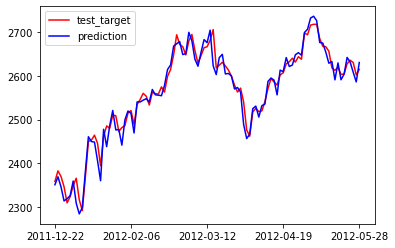

In [9]:
model.eval()
pred = []
test_target = []
for x, label in test_loader :
    x, label = x.cuda(), label.cuda()
    out = model(x)
#     print(out)
    test_target.append(label.detach().cpu())
    pred.append(out.detach().cpu())
test_target = torch.cat(test_target, dim = 0).numpy().squeeze()#将各个batch的输出进行拼接，转成数组再进行降维
pred = torch.cat(pred, dim = 0).numpy().squeeze()

test_target = test_target * (max_high - min_high) + min_high#还原原始的数据
pred = pred * (max_high - min_high) + min_high
test_index = np.array(test_index)
plt.plot(test_index[ : 101][ : : -1], test_target[ : 101][ : : -1], 'r', label = 'test_target')
plt.plot(test_index[ : 101][ : : -1], pred[ : 101][ : : -1], 'b', label = 'prediction')
plt.legend(loc = 'upper left')
plt.xticks(np.arange(0,101,25), [test_index[100], test_index[75], test_index[50], test_index[25], test_index[0]])
plt.show()

*看上去效果还是很不错的*